# Customer Behaviour Insight Enginge - Notebook 6c
## CBS Integration - Device Mix Comparison 

**Goal of 6c**

Integrated in this notebook: 

- THe cleaned CBS digital adoption data (`cbs_digital_clean.csv`)
- The synthetic e-commer dataset from Kaggle (`sessions_enriched.csv`)

to compare:

- The cleaned CBS digital adoption data
- With the Dutch national patterns of mobile internet use (smartphone / table / other mobile)


In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", "{:.2f}".format)

## 1. Load cleaned CBS data and site sessions 

- `../data/processed/cbs_digital_clean.csv'
    -> Tidy table from Notebook 6b (`year`, `device_category`, `share_pct`)

- `../data/processed/sessions_enriched.csv`
    -> Sesseion-level data from earlier notebooks with a `device` column.

In [18]:
processed_path = "../data/processed/"

cbs_devices = pd.read_csv(processed_path + "cbs_digital_clean.csv")

print("CBS devices shape:", cbs_devices.shape)
display(cbs_devices.head())

sessions_enriched = pd.read_csv(processed_path + "sessions_enriched.csv")

print("'nSessions enriched shape:", sessions_enriched.shape)
print("Columns:", sessions_enriched.columns.tolist())

print("\nDevice value counts:")
print(sessions_enriched["device"].value_counts(dropna=False))

CBS devices shape: (40, 3)


,year,device_category,share_pct
0,2012,mobile_total,51.40
1,2013,mobile_total,60.70
2,2014,mobile_total,65.90
3,2015,mobile_total,71.10
4,2016,mobile_total,73.20


'nSessions enriched shape: (120000, 17)
Columns: ['session_id', 'customer_id', 'start_time', 'device', 'source', 'country', 'session_start', 'session_end', 'session_duration_min', 'n_events', 'n_page_views', 'n_add_to_cart', 'n_checkout', 'n_purchase', 'total_qty', 'session_revenue', 'made_purchase']

Device value counts:
device
mobile     65942
desktop    45547
tablet      8511
Name: count, dtype: int64


## 2. Site device mix (sessions by device)

To:

- Count how many sessions use each device 
- Convert that into percentages of all sessions 
- Create a small, clean table that can be compared to CBS data.

In [19]:
# 2.1 Count sessions per device 
device_counts = (
    sessions_enriched
    .groupby("device")["session_id"]
    .nunique()
    .reset_index(name="n_sessions")
    .sort_values("n_sessions", ascending=False)
    
    )

total_sessions = device_counts["n_sessions"].sum()
device_counts["share_pct"] = (device_counts["n_sessions"] / total_sessions * 100).round(1)

print("Site device counts and shares:")
device_counts 

Site device counts and shares:


,device,n_sessions,share_pct
1,mobile,65942,55.00
0,desktop,45547,38.00
2,tablet,8511,7.10


## 3. Align site metrics with CBS device categories 

The CBS data has: 

- `mobile_total`, - "any mobile device"
- `smarptphone`
- `tablet`
- `other_mobile`

My site has (from the value counts above:)

- `desktop`
- `mobile`
- `tablet`
- (possibly other minor catgories)

To make them comparable: 

**From the stie data**

- `site_mobile_total_pct` = `% of sessions on mobile OR tablet`
- `site_smartphone_pct` = `% or sessions on mobile`
- `site_tablet_pct` = `% of sessions on tablet`

`laptop` and `other_mobile` is ignored site-side becuase the Kaggle dataset doesn't distinguish them as separate devices.

In [20]:
# Helper to safely get percentage for a device label
site_share_by_device = (
    device_counts.set_index("device")["share_pct"].to_dict()
)

site_mobile_pct = site_share_by_device.get("mobile", 0.0)
site_tablet_pct = site_share_by_device.get("tablet", 0.0)

# Total "mobile" usage on site = mobile + tablet
site_mobile_total_pct = round(site_mobile_pct + site_tablet_pct)

print("Derived site metrcs:")
print("site_mobile_total_pct:", site_mobile_total_pct)
print("site_smartphone_pct:", site_mobile_total_pct)
print("site_tablet_pct:", site_tablet_pct)

Derived site metrcs:
site_mobile_total_pct: 62
site_smartphone_pct: 62
site_tablet_pct: 7.1


## 4. Choose a CBS reference year 

The CBS data covers 2012-2019.
The synthetic e-commerce data is not tied to a specific real year, but to keep things realistic: 

- Use **2019** as the reference year (latest available in this table)
- Interpret that as "roughly current" device usage in the Netherlands

In [21]:
cbs_2019_df = cbs_devices[cbs_devices["year"] == 2019].copy()
cbs_2019_df

,year,device_category,share_pct
7,2019,mobile_total,84.40
15,2019,smartphone,82.50
23,2019,laptop,35.00
31,2019,tablet,27.50
39,2019,other_mobile,10.90


In [22]:
cbs_2019_pivot = (
    cbs_2019_df
    .set_index("device_category")["share_pct"]
    .to_dict()
)

cbs_2019_pivot

{'mobile_total': 84.4,
 'smartphone': 82.5,
 'laptop': 35.0,
 'tablet': 27.5,
 'other_mobile': 10.9}

## 5. Build CBS vs Site comparison table 

Focus is on device types that can be reasonably matched: 

- `mobile_total`
- `smartphone`
- `tablet`

For each include: 

- `cbs_pct` - % of Dutch population (12+) using internet on that device type
- `site_pct` - % of sessions on that device type (or combination)

In [27]:
device_compare = pd.DataFrame([
    {
        "Device Category": "Any mobile device",
        "CBS (2019)": cbs_2019_pivot["mobile_total"],
        "Site (%)": site_mobile_total_pct,
        "Interpretation": "Broad mobile usage: smartphone + tablet on site vs CBS 'any mobile'."
    },
    {
        "Device Category": "Smartphone",
        "CBS (2019)": cbs_2019_pivot["smartphone"],
        "Site (%)": site_mobile_pct,
        "Interpretation": "Site 'mobile' traffic approximates smartphone usage."
    },
    {
        "Device Category": "Tablet",
        "CBS (2019)": cbs_2019_pivot["tablet"],
        "Site (%)": site_tablet_pct,
        "Interpretation": "Direct tablet-to-tablet comparison."
    },
])

device_compare["Difference (Site - CBS)"] = (
    device_compare["Site (%)"] - device_compare["CBS (2019)"]
).round(1)

device_compare

,Device Category,CBS (2019),Site (%),Interpretation,Difference (Site - CBS)
0,Any mobile device,84.40,62.00,Broad mobile usage: smartphone + tablet on sit...,-22.40
1,Smartphone,82.50,55.00,Site 'mobile' traffic approximates smartphone ...,-27.50
2,Tablet,27.50,7.10,Direct tablet-to-tablet comparison.,-20.40


### Interpretation Summary

Compared to Dutch national behaviour in 2019: 

-**Smartphone usage on the site is significationlt lower (55% vs 82.5%)**, suggesting the site is not fully optimized for mobile-first usage patterns typical in the Netherlands.
- **Tablet usage is much loer on the site (7.1% vs 27.5%)**, possibly indicating either device incompatibility or product type difference. 
-**Overall mobile usage (mobile + tablet) is lower on the site (62% vs 84.4%)**, suggestiing an opportunity to improve mobile experience and capture more mobile traffic.

### 6. Visualize CBS vs Site device mix 

Create a simple bar chart to show: 

- For each metric (mobile_total, smartphone, tablet)
- CBS percentage vs Site percentage 

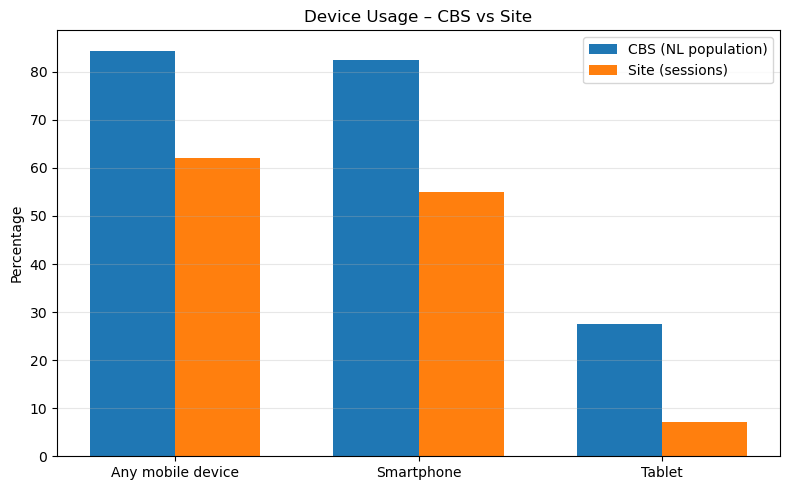

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Figure out which column names we actually have
if "cbs_pct" in device_compare.columns and "site_pct" in device_compare.columns:
    cbs_col = "cbs_pct"
    site_col = "site_pct"
elif "CBS (2019)" in device_compare.columns and "Site (%)" in device_compare.columns:
    cbs_col = "CBS (2019)"
    site_col = "Site (%)"
else:
    raise ValueError("Could not detect CBS / Site columns in device_compare.")

if "metric" in device_compare.columns:
    label_col = "metric"
elif "Device Category" in device_compare.columns:
    label_col = "Device Category"
else:
    raise ValueError("Could not detect label column (metric / Device Category).")

# Now build the bar chart
plt.figure(figsize=(8, 5))

x = np.arange(len(device_compare))
width = 0.35

plt.bar(x - width/2, device_compare[cbs_col],  width, label="CBS (NL population)")
plt.bar(x + width/2, device_compare[site_col], width, label="Site (sessions)")

plt.xticks(x, device_compare[label_col])
plt.ylabel("Percentage")
plt.title("Device Usage – CBS vs Site")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()